# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `11`
* Students: `Hajri Mortiniera Wagner Gomez`
* Dataset: `FMA Free Music Archive`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import collections

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = np.load('patrik_adjacency.npy')
n_nodes = len(adjacency)
n_nodes

2259

In [4]:
labels = np.load('patrik_labels.npy')
labels

array(['Rock', 'Rock', 'Rock', ..., 'Hip-Hop', 'Rock', 'Rock'],
      dtype=object)

In [5]:
colors = np.where(labels=='Rock', 'r', 'b')
rock = collections.Counter(labels)['Rock']
hiphop = collections.Counter(labels)['Hip-Hop']

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [6]:
laplacian_combinatorial = sparse.csgraph.laplacian(adjacency, normed=False)
laplacian_normalized =  sparse.csgraph.laplacian(adjacency, normed=True)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [7]:
eigComb = np.linalg.eigh(laplacian_combinatorial)
eigNorm = np.linalg.eigh(laplacian_normalized)

comb_vectors = eigComb[1]
comb_values = eigComb[0]
norm_vectors = eigNorm[1]
norm_values = eigNorm[0]

True
True


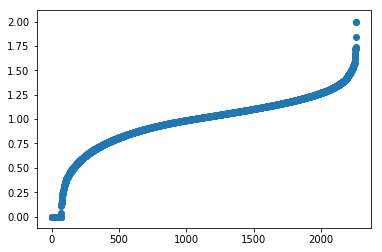

In [10]:
print(np.array_equal(comb_values, np.sort(comb_values)))
print(np.array_equal(norm_values, np.sort(norm_values)))
plt.scatter(np.arange(1,n_nodes+1), norm_values)

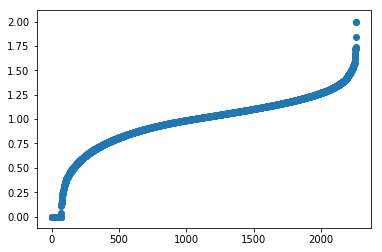

In [12]:
#since we have very small negative values (10^-15) so we round them to 0
norm_values = np.where(np.abs(norm_values) < 10e-5 , 0, norm_values)
plt.scatter(np.arange(1,n_nodes+1), norm_values)

We have around 300 0-values, and our maximal value is approximately 2.

the eigenvalues are sorted in ascending order

Justify your choice of eigensolver.

In [13]:
# create inverse of eigenvectors matrix
R = np.linalg.inv(comb_vectors)
# create diagonal matrix from eigenvalues
L = np.diag(comb_values)
# reconstruct the original matrix
B = comb_vectors.dot(L).dot(R)
print("Original Combinatorial Matrix :\n")
print(laplacian_combinatorial,'\n')
print("Combinatorial Reconstruction :\n")
print(np.round(B).astype(int))
np.array_equal(laplacian_combinatorial, np.round(B).astype(int))

Original Combinatorial Matrix :

[[27  0  0 ...  0  0  0]
 [ 0 88  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 25  0]
 [ 0  0  0 ...  0  0  2]] 

Combinatorial Reconstruction :

[[27  0  0 ...  0  0  0]
 [ 0 88  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ... 12  0  0]
 [ 0  0  0 ...  0 25  0]
 [ 0  0  0 ...  0  0  2]]


True

We can see that the reconstruction from the eigenvalues and eigenvectors, after rounding, is equal to the original matrix which justifies the choice of solver.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

S is the Incidence matrix whose rows are indexed by the vertices and whose columns are indexed by the edges of G such that each column corresponding to an edge e = $v_i$$v_j$ (with i<j) has entry 1 in the row corresponding to $v_i$, and entry −1 in the row corresponding to $v_j$, and has zero entries elsewhere. $S^\top x$, with $x \in \mathbb{R}^N$, computes the gradient of x

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

$\lambda_ku_k = Lu_k\\
\lambda_ku_k = SS^\top u_k\\ 
u_k^\top\lambda_ku_k = u_k^\top SS^\top u_k\\
\lambda_ku_k^\top u_k = (S^\top u_k)^\top (S^\top u_k)\\ 
\lambda_k = \| S^\top u_k \|_2^2 $

What does the quantity $\| S^\top x \|_2^2$ tells us about $x$?

**Your answer here.**

This represents the energy of the gradient of X.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

u0 describes a component of the graph if the u0[i] == 0, it means that node i is not in this component, otherwise if u0[i] != 0, it means that the node i is in the component. if n_u0[i] == 0 for the normalized laplacian, then c_u0[i] == 0 for the combinatorial laplacian

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

In [14]:
norm_values[-1]

2.0000000000000004

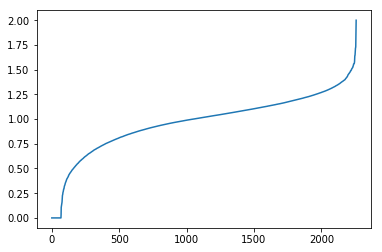

In [15]:
plt.plot(norm_values)

All the values are between 0 and 2, this is a good thing because we know that in theory the eigenvalues of a normalized laplacian are between 0 and 2. the first ~300 eigenvalues are equal to 0, this multplicity gives us the number of components of our graph. This is known as the spectral gap.

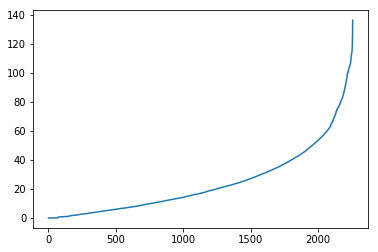

In [16]:
plt.plot(comb_values)

We see that all the eigenvalues are positive, indeed the laplacian matrix is positive definite. This time the eigenvalues are no more strictly upperbounded.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [17]:
CC = len(norm_values[norm_values==0])
print("There are {} connected components. this is coherent as observed in the normalized laplacian spectral plot."\
      .format(CC))

There are 69 connected components. this is coherent as observed in the normalized laplacian spectral plot.


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

Let A be a positive square matrix. Then the maximal row sum is an upper bound of $λ_{max}$. If the Laplacian is normalized then 2 is an upperbound

In [18]:
print('For the combinatorial laplacian, the maximal eigenvalue is {} but this is an internal property of our matrix.'\
      .format(max(sum(adjacency))))

For the combinatorial laplacian, the maximal eigenvalue is 135 but this is an internal property of our matrix.


## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**It is usually used for dimensionality reduction and representation of complex data while preserving specific properties of the graph such as locality and clusters by embedding similar points close to each other.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [21]:
def embed(M, matrix):
    d, u = np.linalg.eigh(M)
    U = u[:,69:71]
    Z = np.matmul(matrix, U)
    return Z

Plot the nodes embedded in 2D. Comment on what you see.

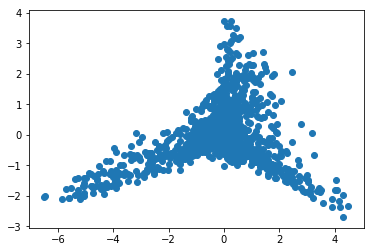

In [22]:
EmbedMatrix = embed(laplacian_normalized, adjacency)
plt.scatter(EmbedMatrix[:,0], EmbedMatrix[:, 1])

**We can see 3 spikes and we see a kind of trend**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**It preserves local neighborhood information of nodes.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**As stated above, we expect to have k=2 representing our two genre clusters : Rock and Hip-hp.
We choose d = 2 for visualisation issues.** 

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

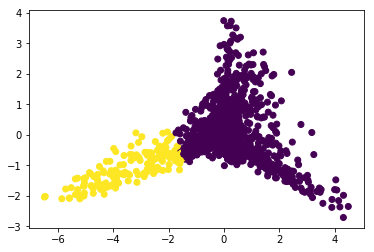

In [23]:
out = EmbedMatrix
kmeans = KMeans(n_clusters = 2)
kmeansoutput = kmeans.fit(out)
plt.scatter(out[:,0], out[:,1], c=kmeans.labels_)

It seems that kmeans autmatically assign colors for each computed clusters, but we are not sure if they have been assigned randomly or not.

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [24]:
center = kmeans.cluster_centers_
left = []
right = []
for point_indice in range(len(out)):
    p = out[point_indice]
    A = True if np.linalg.norm(p-center[0]) < np.linalg.norm(p - center[1]) else False
    if A:
        left.append(point_indice)
    else :
        right.append(point_indice)

In [25]:
new_adj = []
new_colors = []
for i in left:
    new_adj.append(adjacency[i])
    new_colors.append(colors[i])
for j in right:
    new_adj.append(adjacency[j])
    new_colors.append(colors[j])
new_adj = np.array(new_adj)

We divide the columns of our adjacency matrix in 2 clusters (left, right) according to the 2 cluster centers. 

In [26]:
print('ww have 2 cluster of size {} and {}'.format(len(left), len(right)))
print('we have {} rock nodes, and {} hip-hop nodes'.format(rock, hiphop))

ww have 2 cluster of size 2092 and 167
we have 1784 rock nodes, and 475 hip-hop nodes


We can wee that the number of nodes in each cluster is very near from what we expect.

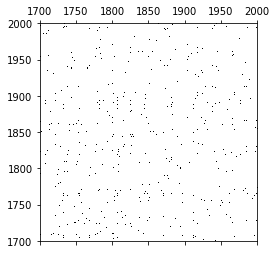

In [27]:
plt.spy(new_adj)
plt.xlim(1700,2000)
plt.ylim(1700,2000)
plt.show()

Surprisingly, we expected to notice two squares representing each cluster (rock and hip hop), however, it seems that something is wrong in our code.

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

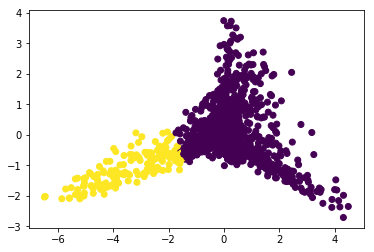

In [28]:
plt.scatter(out[:,0], out[:,1], c=kmeans.labels_)

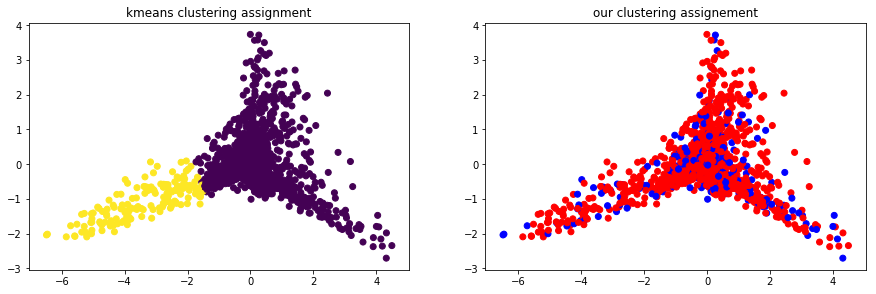

In [29]:
plt.figure(1, figsize=(15,10))
plt.subplot(221)
plt.title('kmeans clustering assignment')
kmeans = KMeans(n_clusters = 2)
kmeansoutput = kmeans.fit(out)
plt.scatter(out[:,0], out[:,1], c=kmeans.labels_)
plt.subplot(222)
plt.title('our clustering assignement')
kmeans = KMeans(n_clusters = 2)
kmeansoutput = kmeans.fit(out)
plt.scatter(out[:,0], out[:,1], c=new_colors)

As expected based on our new adjacency matrix, we don't any clustering with our ground truth. 

In [30]:
print('The percentage of error of our clusters assignment is {}',format(np.abs(len(left) - rock)/rock))

The percentage of error of our clusters assignment is {} 0.1726457399103139


### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

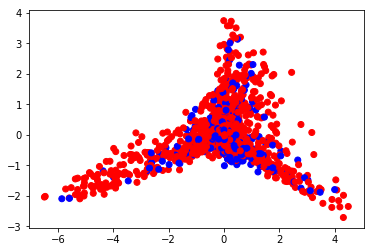

In [31]:
plt.scatter(EmbedMatrix[:,0], EmbedMatrix[:, 1], c=colors)

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**We could have used Principal component analysis (PCA) to capture the principal component, and capture the two directions with largest variances.**